In [60]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
import random
import cv2 as cv

In [61]:
# GLOBAL VARIABLES 
os.chdir('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles')
print("Working Directory:", os.getcwd())

# directories containing desired output, i.e. our y-labels, the ground truth 
base_path = "ObjectDetectedDataset/"
inputTrainPath = base_path + "train/edge_detected"
inputTestPath = base_path + "test/edge_detected" 

outputTrainPath = base_path + "train/tom_jerry_images"
outputTestPath = base_path + "test/tom_jerry_images"

trainingDirectories = [inputTrainPath, outputTrainPath]
testingDirectories = [inputTestPath, outputTestPath]


Working Directory: /Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles


In [62]:
# HELPER FUNCTIONS
""" Returns file paths for all images in the input and output directories

    Returns:
        List(Tuples): each tuple contains paths to two corresponding images, the first is the edge-filtered image, the second is the unaltered image
"""
def getFilePaths(inputDirectories, outputDirectories): 
    dataset = []
    for inputDir, outputDir in zip(inputDirectories, outputDirectories): 
        fileNames = os.listdir(inputDir)
        for fileName in fileNames: 
            inputImagePath = os.path.join(inputDir, fileName)
            outputImagePath = os.path.join(outputDir, fileName)
            dataset.append((inputImagePath, outputImagePath))
    return dataset

# takes in two paths of paired images, 
# optionally, one can specify the desired resolution of the image
# whether to display the retrieved images, and whether to convert the images to RGB
# will return the two images as numpy arrays, normalized by dividing by 255
""" Returns two images as two numpy arrays, normalized by dividing by 255

    Args: 
        input_file_path (str): path to an edge-filtered image
        output_file_path (str): path corresponding to the un-modified image of the input_file_path
        image_shape Tuple(int, int): desired width and length of the image
        showImages (boolean): whether to display both images using matplotlib
        isRGB (boolean): whether to convert

    Returns: 
        (np.array, np.array): Two rescaled numpy arrays, representing two images
"""
def loadImage(input_file_path, output_file_path, 
              image_shape=(400, 200), showImages=False, isRGB = True): 

    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
    # print("Inside loadImage():", np.min(beforeGrayScale), np.max(beforeGrayScale))

    # convert to greyscale if desired
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")

    # if desired, display the retrieved images
    if showImages: 
        # Display images for testing
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(np.array(input_image))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(np.array(output_image))
        plt.title("Ground Truth Image")
        plt.axis('off')

        plt.show()
    # for some reason, max pixel value from edge_detected images is 118.0
    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [63]:
trainingPaths = getFilePaths([trainingDirectories[0]], [trainingDirectories[1]])
testingPaths = getFilePaths([testingDirectories[0]], [testingDirectories[1]])

maxesOfInput = []
maxesOfOutput = []
# for i in range(len(paths)): 
#     randomNum = random.randint(0, len(paths)-1)
#     result = loadImage(paths[randomNum][0], paths[randomNum][1], image_shape=(28,28), showImages=False, isRGB=False)
#     maxesOfInput.append(np.max(result[0]))
#     maxesOfOutput.append(np.max(result[1]))
    # print(np.min(result[0]), np.max(result[0]))
    # print(np.min(result[1]), np.max(result[1]))
# print(max(maxesOfInput))
# print(max(maxesOfOutput))


In [64]:
# CREATION OF TRAINING AND TESTING DATASETS

# randomize paths so images are randomly allocated into training/testing datasets
# random.shuffle(paths)
validation_split = 0.2

x_train, y_train = [], []
x_test, y_test = [], []


# THIS VARIABLE AFFECTS THE DIMENSIONS OF ALL IMAGES IN THE DATASET
# IT WILL ALSO AFFECT THE SHAPE OF THE AUTO_ENCODER
personal_image_shape = (128, 128)
for train_input_path, train_output_path in trainingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_train.append(inputImage)
    y_train.append(outputImage)

for train_input_path, train_output_path in testingPaths: 
    inputImage, outputImage = loadImage(train_input_path, train_output_path, image_shape=personal_image_shape, isRGB=False, showImages=False)
    x_test.append(inputImage)
    y_test.append(outputImage)


# print(np.min(result[0]/255.0), np.max(result[0]/255.0))
# print(np.min(result[1]/255.0), np.max(result[1]/255.0))

In [65]:
# Confirming sizes of datsets and shapes of the datasets
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

983 983
368 368
(983, 128, 128)
(983, 128, 128)
(368, 128, 128)
(368, 128, 128)


In [66]:
# following guidance from the below link
# https://www.tensorflow.org/tutorials/load_data/numpy
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [67]:
# latent_dimensions = 150
# cnn = Sequential()
# #
# cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(personal_image_shape[1], personal_image_shape[0], 1)))
# cnn.add(MaxPooling2D((2, 2), padding='same'))
# cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# cnn.add(MaxPooling2D((2, 2), padding='same'))
# cnn.add(Conv2D(16, (3, 3), activation='relu', padding='same'))

# cnn.add(Flatten())
# cnn.add(Dense(latent_dimensions, activation='relu'))

# cnn.add(Dense(16 * (personal_image_shape[1] // 4) * (personal_image_shape[0] // 4), activation='relu'))
# cnn.add(Reshape((personal_image_shape[1] // 4, personal_image_shape[0] // 4, 256)))
# cnn.add(UpSampling2D((2, 2)))
# cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# cnn.add(UpSampling2D((2, 2)))
# cnn.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

In [68]:
class ConvAutoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Added max pooling
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Added max pooling
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')

        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(256 * (input_shape[0] // 4) * (input_shape[1] // 4), activation='relu'),
            layers.Reshape((input_shape[0] // 4, input_shape[1] // 4, 256)),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
            layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [69]:
input_shape = (128, 128, 1)  # Replace with actual image dimensions
latent_dim = 150  # Define your latent space dimensionality
cnn = ConvAutoencoder(input_shape=input_shape, latent_dim=latent_dim)
cnn.compile(optimizer='adam', 
                               loss=losses.MeanSquaredError())
                              #  loss=losses.MeanAbsoluteError())
                              #  loss=losses.BinaryCrossentropy())

callback = EarlyStopping(monitor="val_loss", patience = 15)

history = cnn.fit(train_dataset,
                epochs=1000,
                shuffle=True,
                validation_data=(test_dataset), 
                callbacks=callback)

Epoch 1/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0817 - val_loss: 0.0672
Epoch 2/1000
16/16 [==============================] - 54s 3s/step - loss: 0.0597 - val_loss: 0.0497
Epoch 3/1000
16/16 [==============================] - 55s 3s/step - loss: 0.0457 - val_loss: 0.0420
Epoch 4/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0397 - val_loss: 0.0370
Epoch 5/1000
16/16 [==============================] - 51s 3s/step - loss: 0.0362 - val_loss: 0.0348
Epoch 6/1000
16/16 [==============================] - 52s 3s/step - loss: 0.0346 - val_loss: 0.0334
Epoch 7/1000
16/16 [==============================] - 55s 4s/step - loss: 0.0332 - val_loss: 0.0331
Epoch 8/1000
16/16 [==============================] - 60s 4s/step - loss: 0.0324 - val_loss: 0.0324
Epoch 9/1000
16/16 [==============================] - 62s 4s/step - loss: 0.0322 - val_loss: 0.0318
Epoch 10/1000
16/16 [==============================] - 58s 4s/step - loss: 0.0311 - val_loss: 0.0306

In [70]:
cnn.summary()

Model: "conv_autoencoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 150)               39709590  
                                                                 
 sequential_8 (Sequential)   (None, 128, 128, 1)       39953153  
                                                                 
Total params: 79662743 (303.89 MB)
Trainable params: 79662743 (303.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


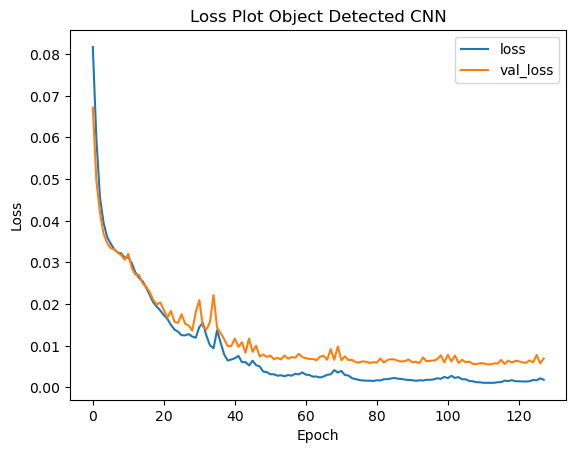

In [71]:
# print training and value loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss Plot Object Detected CNN")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

12/12 [==============================] - 4s 362ms/step


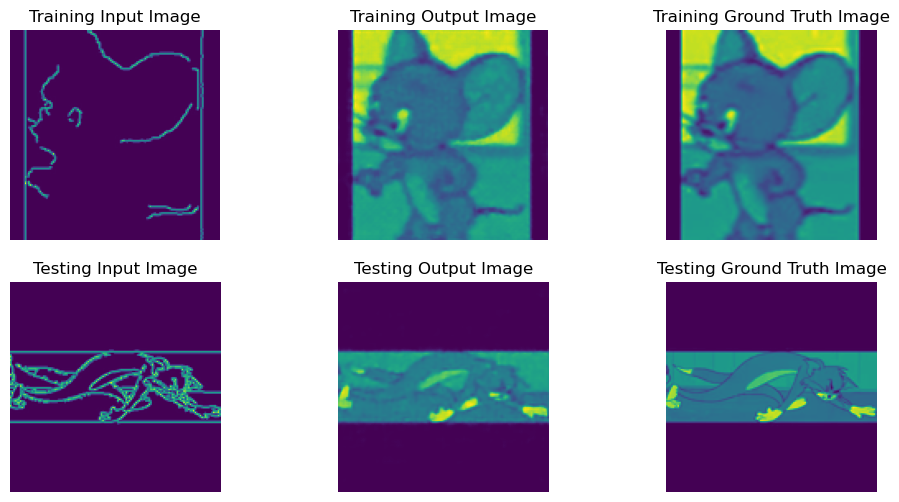

In [72]:

trainImageIndex = random.randint(0, len(x_train)-1)
testImageIndex = random.randint(0, len(x_test)-1)
train_output_image = cnn.predict(x_train)[trainImageIndex]
test_output_image = cnn.predict(x_test)[testImageIndex]

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(np.array(x_train[trainImageIndex]))
plt.title("Training Input Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.array(train_output_image))
plt.title("Training Output Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.array(y_train[trainImageIndex]))
plt.title("Training Ground Truth Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.array(x_test[testImageIndex]))
plt.title("Testing Input Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.array(test_output_image))
plt.title("Testing Output Image")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.array(y_test[testImageIndex]))
plt.title("Testing Ground Truth Image")
plt.axis('off')

plt.show()

In [73]:
cnn.save('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/src/SavedModels/ObjectDetectedCNN2.keras')